# HW1 — Smartphone-Based Sensing of Pendulum Vibrations
Instructor: Mohammad Talebi-Kalaleh  
Course: Sensing Techniques and Data Analytics — Fall 2025

**Student ID:** `STUDENT_ID`  
**Name:** Your Name Here  
**Date:** YYYY-MM-DD  



## Notebook Outline

1. Setup & Imports  
2. Utility functions (data loading, peak detection, damping fit, stats)  
3. Part A — Short Pendulum (L ≈ 0.3 m)  
4. Part B — Long Pendulum (L ≈ 1.0 m)  
5. Part C — Nonlinear Regime (large angles)  
6. Part D — Noise discussion  
7. Figures & Data saving helpers  
8. Submission checklist

Each analysis part includes: data loading, visualization, statistical descriptors, period estimation, damping estimation, and discussion cells.


In [1]:
# Imports and plotting settings
import os
import glob
import numpy as np
import pandas as pd
import scipy.signal as signal
import scipy.optimize as optimize
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

# Ensure figures render in notebook
%matplotlib inline

# Reproducible plotting size policy
plt.rcParams['figure.figsize'] = (10,4)

# Paths (edit STUDENT_ID below)
STUDENT_ID = "STUDENT_ID"
BASE_DIR = f"."
DATA_DIR = os.path.join(BASE_DIR, 'Data')
FIG_DIR = os.path.join(BASE_DIR, 'Figures')



## Theoretical Model

### 2.1 Small-Angle Pendulum Period

For small angular displacements ($\theta \le 15^\circ$), the period of a simple pendulum is given by:
$$T_{n}=2\pi\sqrt{\frac{L}{g}} \quad (1)$$
where:

  * $T\_n$ = oscillation period (seconds)
  * $L$ = pendulum length (meters)
  * $g$ = gravitational acceleration ($9.81 , m/s^2$)

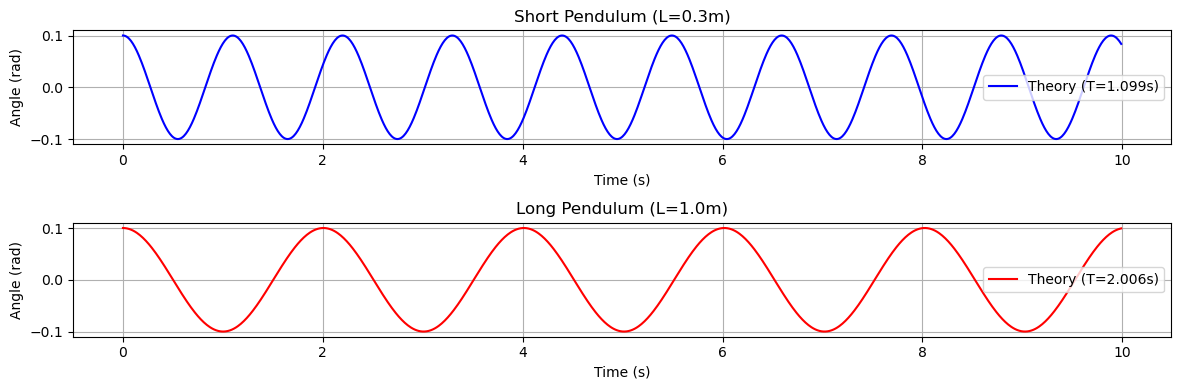

Theoretical periods:
Short pendulum: 1.099s
Long pendulum: 2.006s


In [ ]:
# Generate theoretical data for comparison
def generate_theoretical_pendulum(L, t_max=10, dt=0.01, theta0=15, g=9.81):
    """Generate theoretical pendulum motion for small angles
    Args:
        L (float): pendulum length in meters
        t_max (float): simulation duration in seconds
        dt (float): time step in seconds
        theta0 (float): initial angle in radians
        g (float): gravitational acceleration (m/s^2)
    Returns:
        t, theta: time and angle arrays
    """
    t = np.arange(0, t_max, dt)
    omega = np.sqrt(g/L)  # natural frequency
    theta = theta0 * np.cos(omega * t)  # solution for small angles
    return t, theta

def theoretical_period(L, g=9.81):
    """Calculate theoretical period of a simple pendulum"""
    return 2 * np.pi * np.sqrt(L / g)

# Generate and plot theoretical data for both pendulum lengths
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4))

# Short pendulum
L_short = 0.3 # part A
t_short, theta_short = generate_theoretical_pendulum(L_short)
T_short = theoretical_period(L_short)
ax1.plot(t_short, theta_short, 'b-', label=f'Theory (T={T_short:.3f}s)')
ax1.set_title(f'Short Pendulum (L={L_short}m)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Angle (rad)')
ax1.grid(True)
ax1.legend()

# Long pendulum
L_long = 1.0 # part B
t_long, theta_long = generate_theoretical_pendulum(L_long)
T_long = theoretical_period(L_long)
ax2.plot(t_long, theta_long, 'r-', label=f'Theory (T={T_long:.3f}s)')
ax2.set_title(f'Long Pendulum (L={L_long}m)')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Angle (rad)')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()
print(f'Theoretical periods:\nShort pendulum: {T_short:.3f}s\nLong pendulum: {T_long:.3f}s')

### 2.2 Damped Oscillation Model

The amplitude envelope of a damped pendulum follows exponential decay:
$$A(t)=A_{0} \exp(-\zeta\frac{2\pi}{T_{n}}t) \quad (2)$$
where:

  * $A(t)$ = amplitude at time t
  * $A_0$ = initial amplitude
  * $\zeta$ = damping ratio (dimensionless)
  * $t$ = elapsed time (seconds)

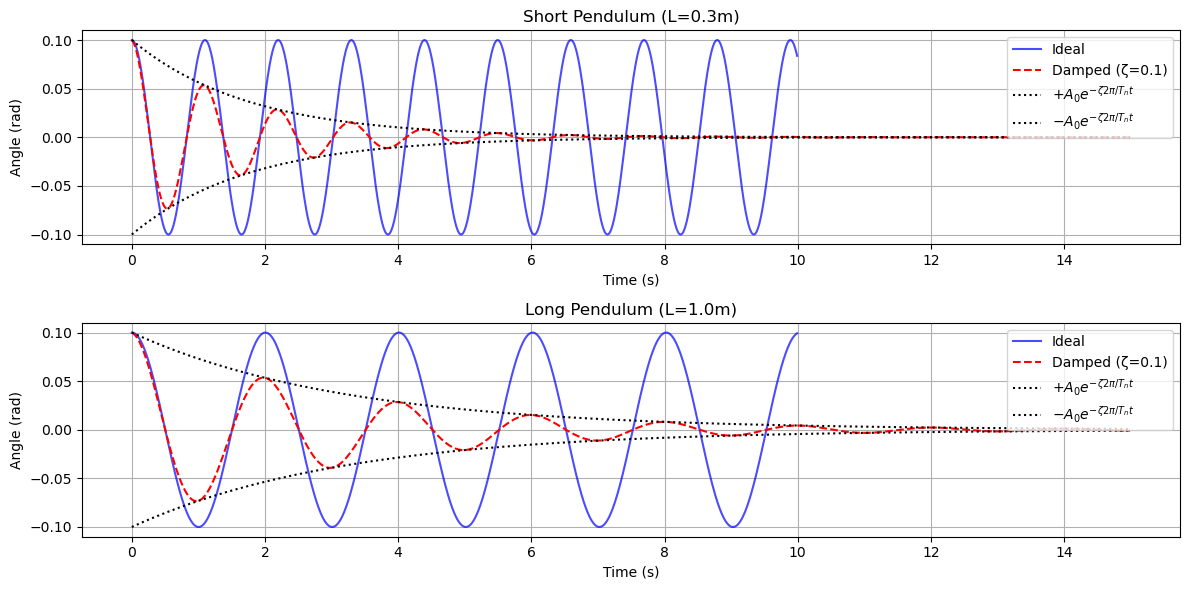

In [12]:
def generate_damped_pendulum(L, t_max=15, dt=0.01, theta0=0.1, zeta=0.1, g=9.81):
    """Generate damped pendulum motion
    Args:
        L (float): pendulum length in meters
        t_max (float): simulation duration in seconds
        dt (float): time step in seconds
        theta0 (float): initial angle in radians
        zeta (float): damping ratio (dimensionless)
        g (float): gravitational acceleration (m/s^2)
    Returns:
        t, theta: time and angle arrays
    """
    t = np.arange(0, t_max, dt)
    omega = np.sqrt(g/L)  # natural frequency
    # Damped solution
    theta = theta0 * np.exp(-zeta * omega * t) * np.cos(omega * t)
    return t, theta

# Plot comparison of ideal vs damped oscillation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Short pendulum comparison
t_short_damped, theta_short_damped = generate_damped_pendulum(L_short, zeta=0.1)
ax1.plot(t_short, theta_short, 'b-', label='Ideal', alpha=0.7)
ax1.plot(t_short_damped, theta_short_damped, 'r--', label='Damped (ζ=0.1)')
ax1.set_title(f'Short Pendulum (L={L_short}m)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Angle (rad)')
ax1.grid(True)

# Long pendulum comparison
t_long_damped, theta_long_damped = generate_damped_pendulum(L_long, zeta=0.1)
ax2.plot(t_long, theta_long, 'b-', label='Ideal', alpha=0.7)
ax2.plot(t_long_damped, theta_long_damped, 'r--', label='Damped (ζ=0.1)')
ax2.set_title(f'Long Pendulum (L={L_long}m)')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Angle (rad)')
ax2.grid(True)



# Add the +- A_0 exp(-zeta 2pi/T_n t) lines
for ax, t, theta0, Tn in [
    (ax1, t_short_damped, 0.1, theoretical_period(L_short)),
    (ax2, t_long_damped, 0.1, theoretical_period(L_long))
]:
    envelope = theta0 * np.exp(-0.1 * 2 * np.pi / Tn * t)
    ax.plot(t, envelope, 'k:', label=r'$+A_0 e^{-\zeta 2\pi/T_n t}$')
    ax.plot(t, -envelope, 'k:', label=r'$-A_0 e^{-\zeta 2\pi/T_n t}$')

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [4]:
# Utility functions

def load_trial_csv(path):
    """Load CSV exported from PhyPhox. 
    Assumes time column 'time' (s) and acceleration axis 'accel' aligned with swing direction.
    Adjust column names below if your CSV uses different headers."""
    df = pd.read_csv(path)
    # Try common column names
    for col in ['time', 't', 'Time']:
        if col in df.columns:
            time_col = col
            break
    else:
        time_col = df.columns[0]
    # choose accel axis heuristically
    accel_col = None
    for col in ['accel_x', 'accel_y', 'accel_z', 'acceleration', 'acc']:
        if col in df.columns:
            accel_col = col
            break
    if accel_col is None:
        accel_col = df.columns[1] if df.shape[1] > 1 else df.columns[0]
    df = df.rename(columns={time_col: 'time', accel_col: 'accel'})
    return df[['time','accel']]

def compute_descriptors(x):
    return {
        'mean': np.mean(x),
        'variance': np.var(x, ddof=1),
        'rms': np.sqrt(np.mean(np.square(x))),
        'skewness': skew(x),
        'kurtosis': kurtosis(x, fisher=False)  # Pearson's definition
    }

def estimate_period_via_peaks(time, signal_data, prominence=0.5, distance=None):
    # find peaks (positive swings)
    peaks, props = signal.find_peaks(signal_data, prominence=prominence, distance=distance)
    if len(peaks) < 2:
        return np.nan, peaks
    peak_times = time[peaks]
    periods = np.diff(peak_times)
    return periods, peaks

def fit_exponential_decay(peak_times, peak_amps, Tn=None):
    """Fit A(t) = A0 * exp(-zeta * 2*pi / Tn * t)
    If Tn is None, fit exponent parameter directly as A0 * exp(-k t) and compute zeta from k and Tn supplied per-trial.
    Returns dict with A0, zeta (if possible), k (decay rate), covariance.
    """
    # fit ln(A) = ln(A0) - k t  where k = zeta * 2*pi / Tn
    positive_mask = peak_amps > 0
    t = np.array(peak_times)[positive_mask]
    A = np.array(peak_amps)[positive_mask]
    if len(A) < 2:
        return {'A0': np.nan, 'k': np.nan, 'zeta': np.nan}
    logA = np.log(A)
    coef = np.polyfit(t, logA, 1)
    k = -coef[0]  # because logA = ln(A0) - k t
    A0 = np.exp(coef[1])
    zeta = np.nan
    if Tn is not None and Tn>0:
        zeta = k * Tn / (2*np.pi)
    return {'A0': A0, 'k': k, 'zeta': zeta}

def theoretical_period(L, g=9.81):
    return 2*np.pi*np.sqrt(L/g)


## Part A — Short Pendulum (L ≈ 0.3 m)

**Instructions:** Place CSV files for Part A into `HW1_STUDENTID/Data/` with names like `partA_trial01.csv` ... `partA_trial10.csv`. The code cells below will loop through trials, compute descriptors, estimate period, fit damping, and summarize results.


In [5]:
# Part A analysis loop (short pendulum)
L_short = 0.3  # meters (adjust if measured)
file_pattern = os.path.join(DATA_DIR, 'partA_trial*.csv')
files = sorted(glob.glob(file_pattern))
results = []

for fpath in files:
    df = load_trial_csv(fpath)
    t = df['time'].values
    x = df['accel'].values
    # basic plot
    plt.figure(); plt.plot(t, x); plt.title(f'Raw accel: {os.path.basename(fpath)}'); plt.xlabel('time (s)'); plt.ylabel('accel (units)'); plt.tight_layout()
    # descriptors
    desc = compute_descriptors(x)
    # smoothing for peak detection (optional)
    x_smooth = signal.savgol_filter(x, 11, 3)
    periods, peaks = estimate_period_via_peaks(t, x_smooth, prominence=np.std(x_smooth)*0.5)
    if isinstance(periods, np.ndarray):
        mean_period = np.mean(periods)
        std_period = np.std(periods, ddof=1)
    else:
        mean_period = np.nan
        std_period = np.nan
    # peak amplitudes and times
    peak_times = t[peaks] if len(peaks)>0 else np.array([])
    peak_amps = np.abs(x_smooth[peaks]) if len(peaks)>0 else np.array([])
    decay = fit_exponential_decay(peak_times, peak_amps, Tn=mean_period)
    result = {
        'file': os.path.basename(fpath),
        'mean_period': mean_period,
        'std_period': std_period,
        'A0': decay['A0'],
        'k': decay['k'],
        'zeta': decay['zeta'],
        **desc
    }
    results.append(result)

results_df = pd.DataFrame(results)
results_df


""


## Part B — Long Pendulum (L ≈ 1.0 m)

Repeat analysis from Part A for `partB_trialXX.csv` files. Adjust `L_long` below if your measured length differs.

In [6]:
L_long = 1.0
file_pattern = os.path.join(DATA_DIR, 'partB_trial*.csv')
files = sorted(glob.glob(file_pattern))
# Copy-paste the same loop for Part B (or refactor into a function). For brevity we reuse code:
results_B = []
for fpath in files:
    df = load_trial_csv(fpath)
    t = df['time'].values
    x = df['accel'].values
    x_smooth = signal.savgol_filter(x, 11, 3)
    periods, peaks = estimate_period_via_peaks(t, x_smooth, prominence=np.std(x_smooth)*0.5)
    if isinstance(periods, np.ndarray):
        mean_period = np.mean(periods)
        std_period = np.std(periods, ddof=1)
    else:
        mean_period = np.nan
        std_period = np.nan
    peak_times = t[peaks] if len(peaks)>0 else np.array([])
    peak_amps = np.abs(x_smooth[peaks]) if len(peaks)>0 else np.array([])
    decay = fit_exponential_decay(peak_times, peak_amps, Tn=mean_period)
    desc = compute_descriptors(x)
    result = {
        'file': os.path.basename(fpath),
        'mean_period': mean_period,
        'std_period': std_period,
        'A0': decay['A0'],
        'k': decay['k'],
        'zeta': decay['zeta'],
        **desc
    }
    results_B.append(result)
pd.DataFrame(results_B)


""


## Part C — Nonlinear Regime (Large Angles)

Use `partC_trialXX.csv`. For large angle trials (θ0 > 45°), measure period variation vs amplitude and compare with small-angle theory.

In [7]:
file_pattern = os.path.join(DATA_DIR, 'partC_trial*.csv')
files = sorted(glob.glob(file_pattern))
period_vs_amp = []
for fpath in files:
    df = load_trial_csv(fpath)
    t = df['time'].values
    x = df['accel'].values
    x_smooth = signal.savgol_filter(x, 11, 3)
    periods, peaks = estimate_period_via_peaks(t, x_smooth, prominence=np.std(x_smooth)*0.5)
    peak_times = t[peaks] if len(peaks)>0 else np.array([])
    peak_amps = np.abs(x_smooth[peaks]) if len(peaks)>0 else np.array([])
    if len(peak_amps)>0 and isinstance(periods, np.ndarray):
        period_vs_amp.append({'file': os.path.basename(fpath), 'mean_period': np.mean(periods), 'mean_amp': np.mean(peak_amps)})
pd.DataFrame(period_vs_amp)


""


## Part D — Noise Discussion

Visually inspect signals and write your qualitative assessment here. Use the examples shown in previous plots. Answer: What are possible noise sources? How do they affect period/damping estimation?

## Submission Checklist

- [ ] Export this notebook to PDF: `HW1_{STUDENT_ID}.pdf` (max 20 A4 pages)
- [ ] Create ZIP named `HW1_{STUDENT_ID}.zip` containing:
  - Executed `.ipynb`
  - `Data/` folder with CSVs
  - `Figures/` folder with generated plots
- [ ] Verify all tables are rendered as DataFrames (no screenshots)
- [ ] Confirm all equations and figures are numbered and captioned
- [ ] Ensure reproducibility: all code cells run from top to bottom without manual path edits (except `STUDENT_ID`)

**Good luck!**

In [8]:
# Helper: save summary tables and figures
summary_csv = os.path.join(BASE_DIR, f'summary_{STUDENT_ID}.csv')
if 'results_df' in globals():
    results_df.to_csv(os.path.join(BASE_DIR, 'summary_partA.csv'), index=False)
if 'results_B' in globals():
    pd.DataFrame(results_B).to_csv(os.path.join(BASE_DIR, 'summary_partB.csv'), index=False)
print('Saved summary CSVs to', BASE_DIR)


Saved summary CSVs to .
